## Keras

In [ ]:
from keras.layers import Conv2D, Dense, Dropout, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D
from keras.applications import VGG16, VGG19, ResNet50
from keras.models import Sequential
from keras.optimizers import Adam, RMSprop, SGD
from keras.losses import BinaryCrossentropy, CategoricalCrossentropy
from keras.regularizers import l1, l2
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [29]:
class EyeDiseaseDataset:
    def __init__(self, dataDir):
        self.data_dir = dataDir
   
    def dataPaths(self):
        filepaths = []
        labels = []
        folds = os.listdir(self.data_dir)
        for fold in folds:
            foldPath = os.path.join(self.data_dir, fold)
            filelist = os.listdir(foldPath)
            for file in filelist:
                fpath = os.path.join(foldPath, file)
                filepaths.append(fpath)
                labels.append(fold)
        return filepaths, labels
  
    def dataFrame(self, files, labels):

        Fseries = pd.Series(files, name='filepaths')
        Lseries = pd.Series(labels, name='labels')
        return pd.concat([Fseries, Lseries], axis=1)
   
    def split_(self):
        files, labels = self.dataPaths()
        df = self.dataFrame(files, labels)
        strat = df['labels']
        trainData, dummyData = train_test_split(df, train_size=0.8, shuffle=True, random_state=42, stratify=strat)
        strat = dummyData['labels']
        validData, testData = train_test_split(dummyData, train_size=0.5, shuffle=True, random_state=42, stratify=strat)
        return trainData, validData, testData

In [30]:
import os
dataDir = '/kaggle/input/eye-diseases-classification/dataset'
dataSplit = EyeDiseaseDataset(dataDir)
train_data, valid_data, test_data = dataSplit.split_()

In [44]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def augment_data( train_df, valid_df, test_df, batch_size=32):
    
    channels = 3
    

    train_datagen = ImageDataGenerator(rescale=1/255., horizontal_flip=True, vertical_flip=True, brightness_range=[0.4,1.5], zoom_range=0.3, 
                                   rotation_range=10, width_shift_range=0.2, height_shift_range=0.2)
          
    valid_test_datagen = ImageDataGenerator(rescale=1/255.)
          
    train_generator = train_datagen.flow_from_dataframe(
              train_df,
              x_col='filepaths',
              y_col='labels',
              target_size=(256, 256),
              color_mode='rgb',
              batch_size=batch_size,
              shuffle=True,
              class_mode='categorical'
          )
   
    print("Shape of augmented training images:", train_generator.image_shape)
          
    valid_generator = valid_test_datagen.flow_from_dataframe(
              valid_df,
              x_col='filepaths',
              y_col='labels',
              target_size=(256, 256),
              color_mode='rgb',
              batch_size=batch_size,
              shuffle=True,
              class_mode='categorical'
          )
         
    print("Shape of validation images:", valid_generator.image_shape)
          
    test_generator = valid_test_datagen.flow_from_dataframe(
              test_df,
              x_col='filepaths',
              y_col='labels',
              target_size=(256, 256),
              color_mode='rgb',
              batch_size=batch_size,
              shuffle=False,
              class_mode='categorical'
          )
          
    print("Shape of test images:", test_generator.image_shape)
          
    return train_generator, valid_generator, test_generator
train_augmented, valid_augmented, test_augmented = augment_data(train_data, valid_data, test_data)

Found 3373 validated image filenames belonging to 4 classes.
Shape of augmented training images: (256, 256, 3)
Found 422 validated image filenames belonging to 4 classes.
Shape of validation images: (256, 256, 3)
Found 422 validated image filenames belonging to 4 classes.
Shape of test images: (256, 256, 3)


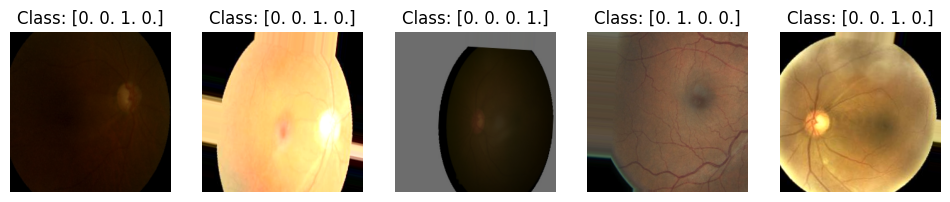

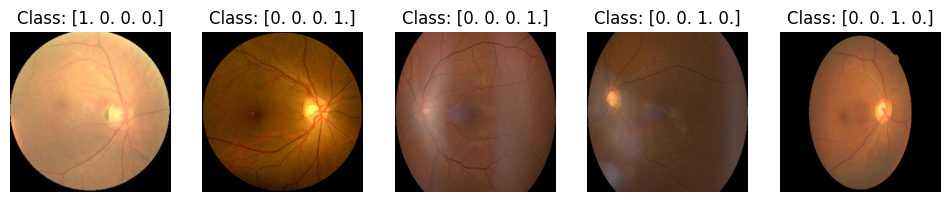

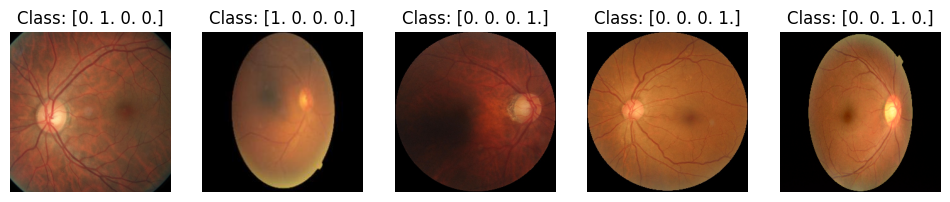

In [45]:
import matplotlib.pyplot as plt

# Function to plot images from a generator
def plot_images(generator, num_images=5):
    # Get a batch of images and labels
    images, labels = next(generator)
    # Plot the images
    plt.figure(figsize=(12, 12))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(images[i])
        plt.title('Class: ' + str(labels[i]))
        plt.axis('off')
    plt.show()

# Display some augmented training images
plot_images(train_augmented)

# Display some augmented validation images
plot_images(valid_augmented)

# Display some augmented test images
plot_images(test_augmented)

In [50]:
# Transfer Learning - 1 (VGG16)

base_model = VGG16(input_shape=(256, 256, 3), include_top=False, weights='imagenet')

base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [51]:
for layer in base_model.layers:
  layer.trainable = False

start_layer_name = 'block5_conv1'

# Find the index of the layer with the specified name
start_layer_index = None
for i, layer in enumerate(base_model.layers):
    if layer.name == start_layer_name:
        start_layer_index = i
        break

# Set layers from the specified layer onwards to trainable
if start_layer_index is not None:
    for layer in base_model.layers[start_layer_index:]:
        layer.trainable = True

In [52]:
layer_1=BatchNormalization()
layer_2 = GlobalAveragePooling2D()
layer_3 = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))
layer_4= Dropout(0.2)
layer_5 = Dense(512, activation='relu', kernel_regularizer=l2(0.01))
layer_6= Dropout(0.2)
layer_7 = Dense(4, activation='softmax')

model=Sequential([
    base_model, layer_1, layer_2, layer_3, layer_4, layer_5, layer_6, layer_7
])

In [49]:
model.compile(optimizer=Adam(learning_rate=0.001), loss = CategoricalCrossentropy(from_logits=False), metrics=['accuracy'])
history=model.fit(train_augmented, epochs=10, validation_data=valid_augmented)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


106/106 ━━━━━━━━━━━━━━━━━━━━ 86s 709ms/step - accuracy: 0.5715 - loss: 7.9756 - val_accuracy: 0.7464 - val_loss: 0.9679
Epoch 2/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 76s 669ms/step - accuracy: 0.7176 - loss: 0.9526 - val_accuracy: 0.4858 - val_loss: 1.8011
Epoch 3/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 76s 665ms/step - accuracy: 0.7649 - loss: 0.7440 - val_accuracy: 0.7986 - val_loss: 0.6918
Epoch 4/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 76s 672ms/step - accuracy: 0.7766 - loss: 0.6605 - val_accuracy: 0.3033 - val_loss: 5.1908
Epoch 5/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 75s 663ms/step - accuracy: 0.7744 - loss: 0.6853 - val_accuracy: 0.7844 - val_loss: 0.6898
Epoch 6/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 75s 665ms/step - accuracy: 0.7996 - loss: 0.6090 - val_accuracy: 0.7251 - val_loss: 0.7947
Epoch 7/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 75s 667ms/step - accuracy: 0.8143 - loss: 0.5933 - val_accuracy: 0.7109 - val_loss: 0.7731
Epoch 8/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 76s 669ms/step - accuracy: 0.7939 - loss: 0.6302 - val

Training Accuracy: 0.8147050142288208
Validation Accuracy: 0.6350710988044739


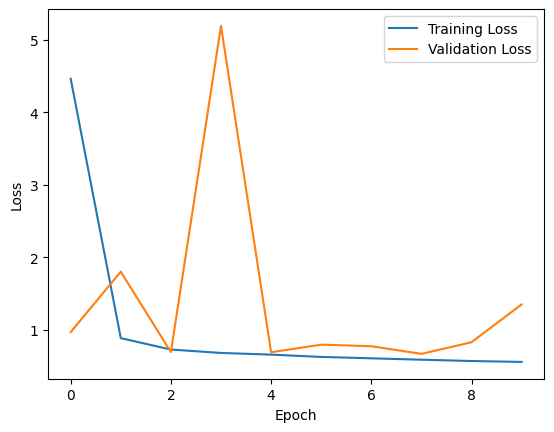

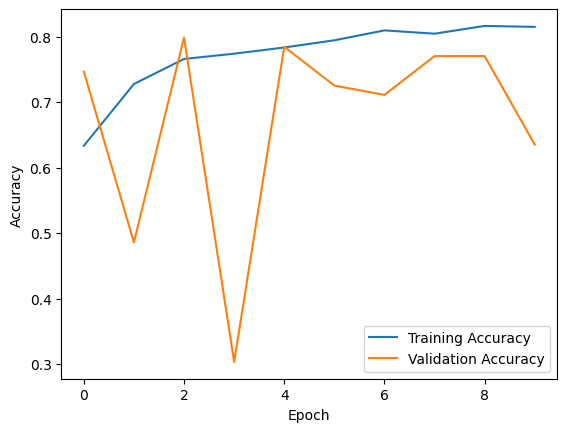

In [53]:
import matplotlib.pyplot as plt
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
print("Training Accuracy:", train_accuracy[-1])
print("Validation Accuracy:", val_accuracy[-1])
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


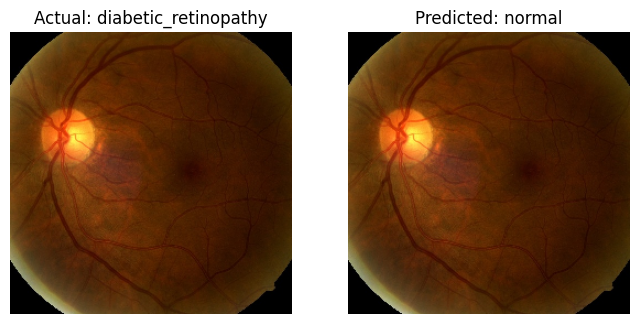

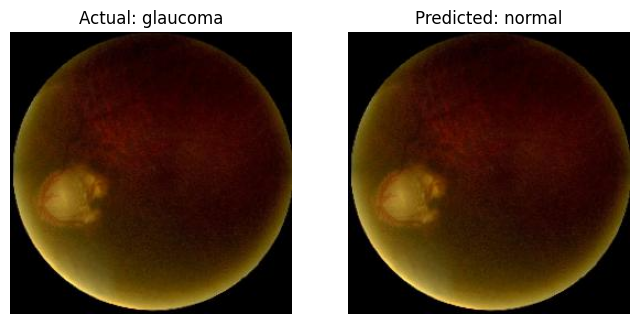

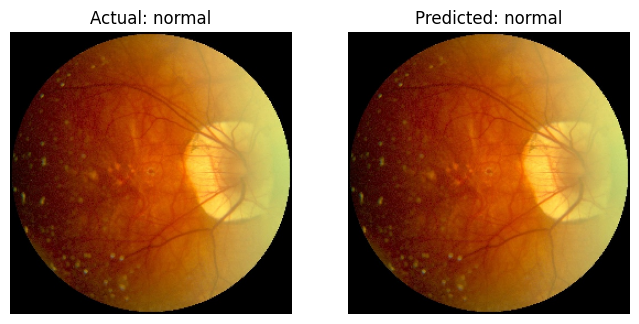

In [54]:
import numpy as np
import matplotlib.pyplot as plt

def plot_actual_vs_predicted(model, test_data, num_samples=3):
    
    # Get a batch of test data
    test_images, test_labels = next(iter(test_data))

    predictions = model.predict(test_images)

    class_labels = list(test_data.class_indices.keys())

    sample_indices = np.random.choice(range(len(test_images)), num_samples, replace=False)
    
    # Plot the images with actual and predicted labels
    for i in sample_indices:
        actual_label = class_labels[np.argmax(test_labels[i])]
        predicted_label = class_labels[np.argmax(predictions[i])]
        plt.figure(figsize=(8, 4))
        # Actual Image
        plt.subplot(1, 2, 1)
        plt.imshow(test_images[i])  # No need to cast to uint8
        plt.title(f'Actual: {actual_label}')
        plt.axis('off')
        # Predicted Image
        plt.subplot(1, 2, 2)
        plt.imshow(test_images[i])  # No need to cast to uint8
        plt.title(f'Predicted: {predicted_label}')
        plt.axis('off')
        plt.show()

# Call the function to plot actual vs predicted images
plot_actual_vs_predicted(model, test_augmented)

## Pytorch

In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import torchvision
from torchvision import transforms, models
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split
import os

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transformations for preprocessing
transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))
])

# Path to the root directory of your dataset containing folders for each disease
data_root = '/kaggle/input/eye-diseases-classification/dataset'

# List all disease folders
disease_folders = [os.path.join(data_root, folder) for folder in os.listdir(data_root)]

# Initialize empty lists to store train and test datasets
train_data = []
test_data = []

# Split each disease dataset into train and test
for folder in disease_folders:
    images = [os.path.join(folder, image) for image in os.listdir(folder)]
    train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)
    train_data.extend(train_images)
    test_data.extend(test_images)

# Create PyTorch datasets
train_dataset = ImageFolder(root=data_root, transform=transform)
test_dataset = ImageFolder(root=data_root, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=40, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=40, shuffle=False)

# Define the model architecture
class EyeDiseaseClassifier(nn.Module):
    def __init__(self, num_classes):
        super(EyeDiseaseClassifier, self).__init__()
        self.base_model = models.resnet50(pretrained=True)
        in_features = self.base_model.fc.in_features
        self.base_model.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.base_model(x)

# Initialize the model
model = EyeDiseaseClassifier(num_classes=len(train_dataset.classes)).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

# Training loop
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100. * correct / total
    return train_loss, train_acc

# Validation loop
def validate(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss /= len(val_loader)
    val_acc = 100. * correct / total
    return val_loss, val_acc

# Training parameters
num_epochs = 5

# Training loop
for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, test_loader, criterion, device)

    print(f'Epoch {epoch+1}/{num_epochs}:')
    print(f'Training Loss: {train_loss:.4f} | Training Accuracy: {train_acc:.2f}%')
    print(f'Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_acc:.2f}%')


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 149MB/s] 


Epoch 1/20:
Training Loss: 0.4884 | Training Accuracy: 81.57%
Validation Loss: 0.2348 | Validation Accuracy: 91.20%
Epoch 2/20:
Training Loss: 0.2349 | Training Accuracy: 91.32%
Validation Loss: 0.1627 | Validation Accuracy: 93.76%
Epoch 3/20:
Training Loss: 0.1777 | Training Accuracy: 93.57%
Validation Loss: 0.2699 | Validation Accuracy: 89.04%
Epoch 4/20:
Training Loss: 0.1584 | Training Accuracy: 94.02%
Validation Loss: 0.0797 | Validation Accuracy: 97.84%
Epoch 5/20:
Training Loss: 0.0922 | Training Accuracy: 97.06%
Validation Loss: 0.0586 | Validation Accuracy: 98.13%
Epoch 6/20:
Training Loss: 0.0645 | Training Accuracy: 97.60%
Validation Loss: 0.0328 | Validation Accuracy: 98.91%
Epoch 7/20:
Training Loss: 0.0608 | Training Accuracy: 97.84%
Validation Loss: 0.0336 | Validation Accuracy: 98.84%
Epoch 8/20:
Training Loss: 0.0378 | Training Accuracy: 98.60%
Validation Loss: 0.0217 | Validation Accuracy: 99.19%
Epoch 9/20:
Training Loss: 0.0240 | Training Accuracy: 99.31%
Validation

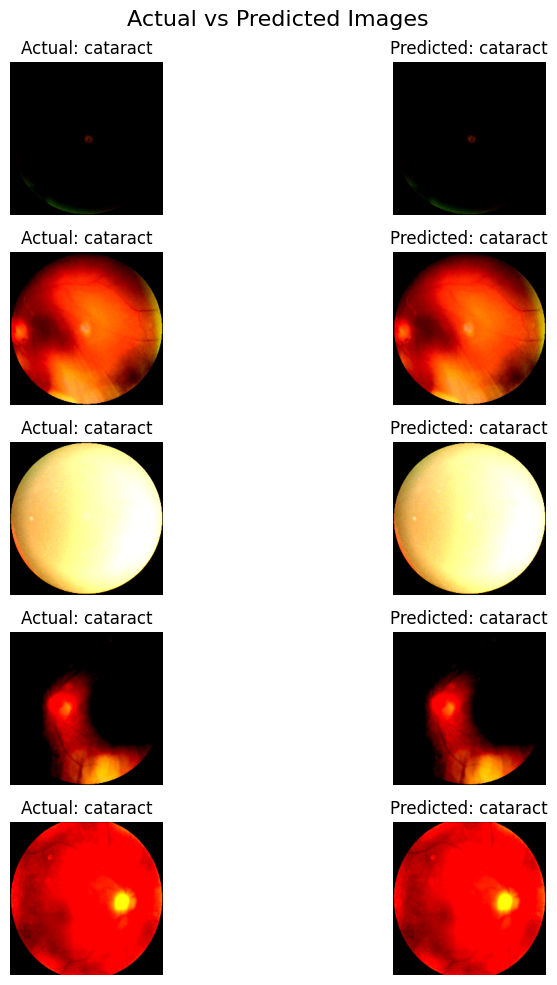

In [20]:
import matplotlib.pyplot as plt
import torch

def plot_images(actual, predicted, images, num_images=5):
    fig, axes = plt.subplots(num_images, 2, figsize=(10, 2*num_images))
    fig.suptitle('Actual vs Predicted Images', fontsize=16)

    count = 0
    for i in range(len(actual)):
        if actual[i] == "cataract":
            image = np.transpose(images[i].cpu().numpy(), (1, 2, 0))
            axes[count, 0].imshow(image)
            axes[count, 0].set_title(f'Actual: {actual[i]}')
            axes[count, 0].axis('off')

            axes[count, 1].imshow(image)
            axes[count, 1].set_title(f'Predicted: {predicted[i]}')
            axes[count, 1].axis('off')

            count += 1
            if count == num_images:
                break
        
        if actual[i] == "glaucoma":
            image = np.transpose(images[i].cpu().numpy(), (1, 2, 0))
            axes[count, 0].imshow(image)
            axes[count, 0].set_title(f'Actual: {actual[i]}')
            axes[count, 0].axis('off')

            axes[count, 1].imshow(image)
            axes[count, 1].set_title(f'Predicted: {predicted[i]}')
            axes[count, 1].axis('off')

            count += 1
            if count == num_images:
                break
        
        if actual[i] == "normal":
            image = np.transpose(images[i].cpu().numpy(), (1, 2, 0))
            axes[count, 0].imshow(image)
            axes[count, 0].set_title(f'Actual: {actual[i]}')
            axes[count, 0].axis('off')

            axes[count, 1].imshow(image)
            axes[count, 1].set_title(f'Predicted: {predicted[i]}')
            axes[count, 1].axis('off')

            count += 1
            if count == num_images:
                break
        
        if actual[i] == "diabetic_retinopathy":
            image = np.transpose(images[i].cpu().numpy(), (1, 2, 0))
            axes[count, 0].imshow(image)
            axes[count, 0].set_title(f'Actual: {actual[i]}')
            axes[count, 0].axis('off')

            axes[count, 1].imshow(image)
            axes[count, 1].set_title(f'Predicted: {predicted[i]}')
            axes[count, 1].axis('off')

            count += 1
            if count == num_images:
                break

    plt.tight_layout()
    plt.show()

# Plot actual and predicted images
plot_images(actual_labels, predicted_labels, [image for image, _ in test_loader.dataset])

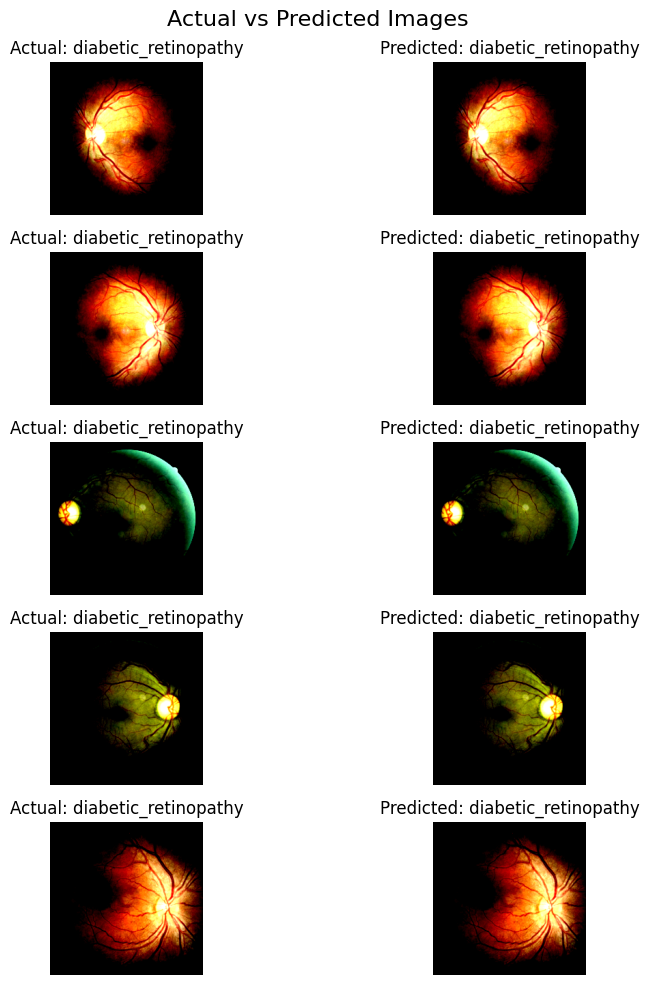

In [21]:
import matplotlib.pyplot as plt
import torch

def plot_images(actual, predicted, images, num_images=5):
    fig, axes = plt.subplots(num_images, 2, figsize=(10, 2*num_images))
    fig.suptitle('Actual vs Predicted Images', fontsize=16)

    count = 0
    for i in range(len(actual)):
        if actual[i] == "glaucoma":
            image = np.transpose(images[i].cpu().numpy(), (1, 2, 0))
            axes[count, 0].imshow(image)
            axes[count, 0].set_title(f'Actual: {actual[i]}')
            axes[count, 0].axis('off')

            axes[count, 1].imshow(image)
            axes[count, 1].set_title(f'Predicted: {predicted[i]}')
            axes[count, 1].axis('off')

            count += 1
            if count == num_images:
                break
        
        if actual[i] == "normal":
            image = np.transpose(images[i].cpu().numpy(), (1, 2, 0))
            axes[count, 0].imshow(image)
            axes[count, 0].set_title(f'Actual: {actual[i]}')
            axes[count, 0].axis('off')

            axes[count, 1].imshow(image)
            axes[count, 1].set_title(f'Predicted: {predicted[i]}')
            axes[count, 1].axis('off')

            count += 1
            if count == num_images:
                break
        
        if actual[i] == "diabetic_retinopathy":
            image = np.transpose(images[i].cpu().numpy(), (1, 2, 0))
            axes[count, 0].imshow(image)
            axes[count, 0].set_title(f'Actual: {actual[i]}')
            axes[count, 0].axis('off')

            axes[count, 1].imshow(image)
            axes[count, 1].set_title(f'Predicted: {predicted[i]}')
            axes[count, 1].axis('off')

            count += 1
            if count == num_images:
                break

    plt.tight_layout()
    plt.show()

# Plot actual and predicted images
plot_images(actual_labels, predicted_labels, [image for image, _ in test_loader.dataset])

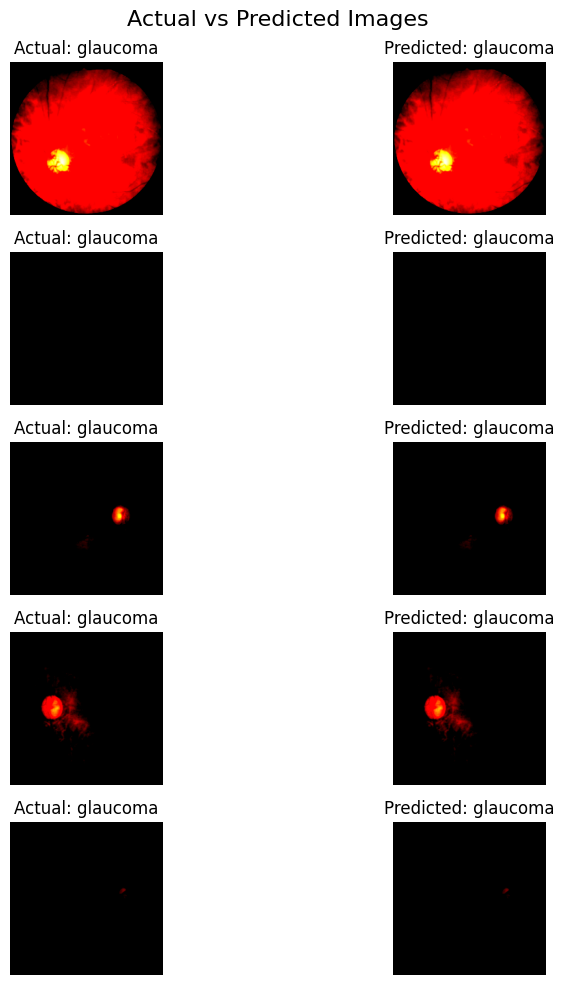

In [22]:
import matplotlib.pyplot as plt
import torch

def plot_images(actual, predicted, images, num_images=5):
    fig, axes = plt.subplots(num_images, 2, figsize=(10, 2*num_images))
    fig.suptitle('Actual vs Predicted Images', fontsize=16)

    count = 0
    for i in range(len(actual)):
        if actual[i] == "glaucoma":
            image = np.transpose(images[i].cpu().numpy(), (1, 2, 0))
            axes[count, 0].imshow(image)
            axes[count, 0].set_title(f'Actual: {actual[i]}')
            axes[count, 0].axis('off')

            axes[count, 1].imshow(image)
            axes[count, 1].set_title(f'Predicted: {predicted[i]}')
            axes[count, 1].axis('off')

            count += 1
            if count == num_images:
                break
        
        if actual[i] == "normal":
            image = np.transpose(images[i].cpu().numpy(), (1, 2, 0))
            axes[count, 0].imshow(image)
            axes[count, 0].set_title(f'Actual: {actual[i]}')
            axes[count, 0].axis('off')

            axes[count, 1].imshow(image)
            axes[count, 1].set_title(f'Predicted: {predicted[i]}')
            axes[count, 1].axis('off')

            count += 1
            if count == num_images:
                break
        
    plt.tight_layout()
    plt.show()

# Plot actual and predicted images
plot_images(actual_labels, predicted_labels, [image for image, _ in test_loader.dataset])

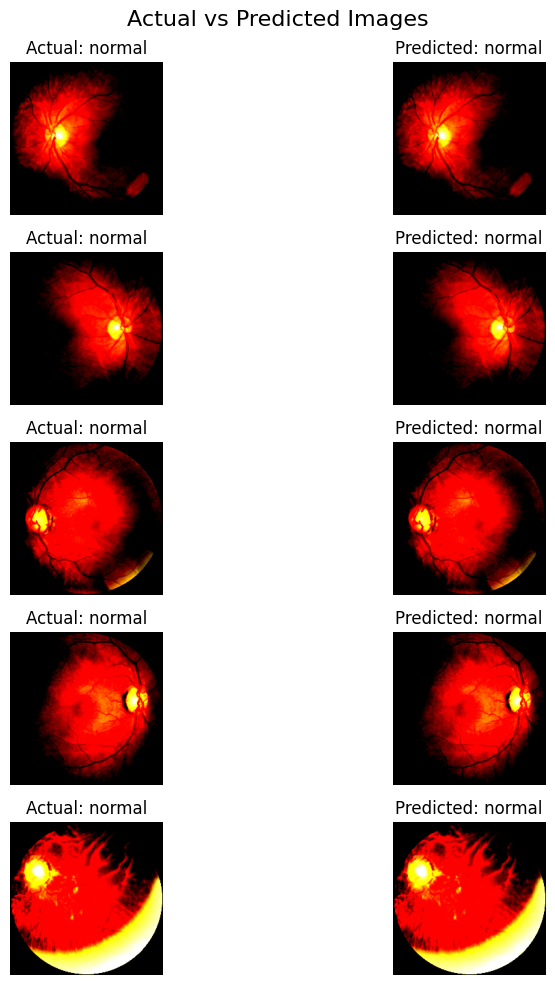

In [23]:
import matplotlib.pyplot as plt
import torch

def plot_images(actual, predicted, images, num_images=5):
    fig, axes = plt.subplots(num_images, 2, figsize=(10, 2*num_images))
    fig.suptitle('Actual vs Predicted Images', fontsize=16)

    count = 0
    for i in range(len(actual)):
        
        if actual[i] == "normal":
            image = np.transpose(images[i].cpu().numpy(), (1, 2, 0))
            axes[count, 0].imshow(image)
            axes[count, 0].set_title(f'Actual: {actual[i]}')
            axes[count, 0].axis('off')

            axes[count, 1].imshow(image)
            axes[count, 1].set_title(f'Predicted: {predicted[i]}')
            axes[count, 1].axis('off')

            count += 1
            if count == num_images:
                break

    plt.tight_layout()
    plt.show()

# Plot actual and predicted images
plot_images(actual_labels, predicted_labels, [image for image, _ in test_loader.dataset])